# Rankings

Another placeholder.

Annual
Daily max and min: tide station
   
Map
Time Series
Samples:
Map showing …highest/lowest observed value at each location (MHHW) 

Plot of Station (relative) Time Series with
Top 10 max an min events …three day window
Color code El Nino, La Nina, neutral …the dots/stars?

Summary Tables and Arrows, Dials. Etc.
Table of Station (relative) Daily
Top 10 max and min events …three day window
Color code El Nino, La Nina, neutral



Text

## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. If you have not run the datawrangling notebook, you will need to do this before running this notebook. Note that this notebook is also largely a repeat of the anomaly notebook. 

```{margin}
```{note}
**TODO**

- Confirm numbers match
- Figure captions
- Figure labels
- Text
- Clean up code
- add commentary
 
```
```

In [40]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 

# We're going to use plotly here, so we need to import it
import plotly.io as pio
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii.nc').exists():
    print('rsl_hawaii.nc not found in '+ str(data_dir) +  '. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in '+ str(data_dir) +  '. Proceed.')

rsl_hawaii.nc found in ../../data. Proceed.


In [41]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_hawaii.nc')
rsl_daily = rsl_daily.sel(time=slice('1993','2023'))

data_coverage = rsl_daily['sea_level'].count(dim='time')/len(rsl_daily.time)

data_coverage
#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

# make sea level relative to MHHW, and convert to m
rsl_subset['sea_level'] = rsl_subset['sea_level'] - rsl_subset['MHHW']
rsl_subset['sea_level'] = rsl_subset['sea_level']/1000

# rename variable long name to sea level relative to MHHW
rsl_subset['sea_level'].attrs['long_name'] = 'sea level, MHHW'
rsl_subset['sea_level'].attrs['units'] = 'm'

In [42]:
# get min and max for each month by resampling
rsl_monthly_min = rsl_subset.resample(time='1ME').min()
rsl_monthly_max = rsl_subset.resample(time='1ME').max()
rsl_monthly_mean = rsl_subset.resample(time='1ME').mean()

In [78]:
rid = 4

def get_top_ten(rsl_subset, rid, mode='max'):
    # Convert data to a pandas Series
    sea_level_series = rsl_subset.sea_level.isel(record_id=rid).to_series()


   # Select top 100 values based on the mode
    if mode == 'max':
        top_values = sea_level_series.nlargest(100)
    elif mode == 'min':
        top_values = sea_level_series.nsmallest(100)
    else:
        raise ValueError('mode must be either "max" or "min"')

    # Filter to find unique events spaced by at least 3 days
    filtered_dates = []
    top_10_values = pd.Series()

    for date, value in top_values.items():
        if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
            filtered_dates.append(date)
            top_10_values[date] = value
        if len(filtered_dates) == 10:
            break
    rank = np.arange(1,11)

    station_name = str(rsl_subset['station_name'].isel(record_id=rid).values)
    record_id = str(rsl_subset['record_id'].isel(record_id=rid).values)  

    top_10_values = pd.DataFrame({'rank': rank, 'date': top_10_values.index, 'sea level (m)': top_10_values.values})  
    top_10_values['station_name'] = station_name
    top_10_values['record_id'] = record_id
    top_10_values['type'] = mode

    #round the date to the nearest hour
    top_10_values['date'] = top_10_values['date'].dt.round('h')

    return top_10_values

In [105]:

def get_top_10_table(rsl_subset,rid):
    # make a table of the top 10 values, sorted by size and with date
    top_10_values_max = get_top_ten(rsl_subset, rid, mode='max')
    top_10_values_min = get_top_ten(rsl_subset, rid, mode='min')

    top_10_table = pd.concat([top_10_values_max,top_10_values_min])

    # cross reference the dates with the oni data to see if they are during an El Nino or La Nina event
    oni = pd.read_csv(data_dir / 'oni.csv', index_col='Date', parse_dates=True)

    # add a new column to oni_min called mode, where mode is either 'El Nino', 'La Nina', or 'Neutral'
    oni['ONI Mode'] = 'Neutral'
    oni.loc[oni['La Nina'] ==True, 'ONI Mode'] = 'La Nina'
    oni.loc[oni['El Nino'] ==True, 'ONI Mode'] = 'El Nino'

    #drop the La Nina and El Nino columns
    oni = oni.drop(columns=['La Nina', 'El Nino'])

    #Extract ONI values for the corresponding dates of top_10_table
    oni_val = oni.reindex(top_10_table['date'], method='nearest')

    # add the oni values to the top_10_table
    top_10_table = pd.merge(top_10_table, oni_val, left_on='date', right_index=True)

    return top_10_table


In [94]:
# subdivide the data into two columns for max and min
# Filter out the 'max' and 'min' types into separate DataFrames
max_top_10 = top_10_table[top_10_table['type'] == 'max'].reset_index(drop=True)
min_top_10 = top_10_table[top_10_table['type'] == 'min'].reset_index(drop=True)

In [95]:
# make table of highest and lowest values by rank, with columns: rank, highest sea level (m), date, lowest sea level (m), date
top_10_display = pd.DataFrame({'Rank':rank,
                             'Highest':max_top_10['sea level (m)'],
                             'Highest Date':max_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Highest ONI Mode':max_top_10['ONI Mode'],
                             'Lowest':min_top_10['sea level (m)'],
                             'Lowest Date':min_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Lowest ONI Mode':min_top_10['ONI Mode'],
                             'Zone': 'GMT'})

top_10_display

,Rank,Highest,Highest Date,Highest ONI Mode,Lowest,Lowest Date,Lowest ONI Mode,Zone
0,1,0.496,2015-09-17 15:00,El Nino,-2.016,2011-03-11 15:00,La Nina,GMT
1,2,0.477,1994-10-04 23:00,El Nino,-1.024,2010-02-28 03:00,El Nino,GMT
2,3,0.474,1995-11-24 14:00,La Nina,-0.952,2011-12-25 06:00,La Nina,GMT
3,4,0.461,2020-12-15 14:00,La Nina,-0.943,1998-06-24 18:00,Neutral,GMT
4,5,0.458,2017-08-21 00:00,Neutral,-0.933,1999-01-02 06:00,La Nina,GMT
5,6,0.453,2021-12-05 14:00,La Nina,-0.923,2001-06-24 21:00,Neutral,GMT
6,7,0.443,2019-12-26 13:00,Neutral,-0.921,2009-05-25 19:00,Neutral,GMT
7,8,0.436,2023-08-02 01:00,El Nino,-0.911,2009-06-23 18:00,Neutral,GMT
8,9,0.433,2020-07-21 01:00,Neutral,-0.910,2009-01-10 05:00,La Nina,GMT
9,10,0.432,2020-07-06 02:00,Neutral,-0.903,2010-01-01 07:00,El Nino,GMT


In [83]:
# Define a function that returns styles for both 'Highest' and 'Lowest' based on respective ONI Modes
def style_oni_based(row):
    styles = {}
    # Color for 'Highest' based on 'Highest ONI Mode'
    if row['Highest ONI Mode'] == 'El Nino':
        styles['Highest'] = 'color: red'
    elif row['Highest ONI Mode'] == 'La Nina':
        styles['Highest'] = 'color: blue'
    else:
        styles['Highest'] = 'color: black'  # Neutral or undefined

    # Color for 'Lowest' based on 'Lowest ONI Mode'
    if row['Lowest ONI Mode'] == 'El Nino':
        styles['Lowest'] = 'color: red'
    elif row['Lowest ONI Mode'] == 'La Nina':
        styles['Lowest'] = 'color: blue'
    else:
        styles['Lowest'] = 'color: black'  # Neutral or undefined

    return pd.Series(styles)

# Apply the styling function to the DataFrame
top_10_display = top_10_display.style.apply(style_oni_based, axis=1).hide(subset=['Highest ONI Mode', 'Lowest ONI Mode'], axis=1).hide()

# Display the styled DataFrame
top_10_display


Rank,Highest,Highest Date,Lowest,Lowest Date,Zone
1,0.496000,2015-09-17 15:00,-2.016000,2011-03-11 15:00,GMT
2,0.477000,1994-10-04 23:00,-1.024000,2010-02-28 03:00,GMT
3,0.474000,1995-11-24 14:00,-0.952000,2011-12-25 06:00,GMT
4,0.461000,2020-12-15 14:00,-0.943000,1998-06-24 18:00,GMT
5,0.458000,2017-08-21 00:00,-0.933000,1999-01-02 06:00,GMT
6,0.453000,2021-12-05 14:00,-0.923000,2001-06-24 21:00,GMT
7,0.443000,2019-12-26 13:00,-0.921000,2009-05-25 19:00,GMT
8,0.436000,2023-08-02 01:00,-0.911000,2009-06-23 18:00,GMT
9,0.433000,2020-07-21 01:00,-0.910000,2009-01-10 05:00,GMT
10,0.432000,2020-07-06 02:00,-0.903000,2010-01-01 07:00,GMT


In [106]:
def make_plotlyFigure(rsl_monthly_mean, rsl_monthly_max, rsl_monthly_min, top_10_table, rsl_subset,rid):
    figly = go.Figure()

    top_10_table = get_top_10_table(rsl_subset,rid)

    x  = rsl_monthly_mean.time - np.timedelta64(15,'D') # add 15 days to make the line in the middle of the month

     #make a fill from max to min for each month
    figly.add_trace(go.Scatter(x =x, y = rsl_monthly_max['sea_level'].isel(record_id=rid), mode='lines', line_color='rgba(0,176,246,0.2)', name='Monthly Max'))
    figly.add_trace(go.Scatter(x =x, y = rsl_monthly_min['sea_level'].isel(record_id=rid), mode='lines', line_color='rgba(0,176,246,0.2)', fill='tonexty', fillcolor='rgba(0,176,246,0.2)', name='Range (Monthly Max/Min)'))

    figly.add_trace(go.Scatter(x =x, y = rsl_monthly_mean['sea_level'].isel(record_id=rid), mode='lines', line_color='rgba(0,176,246,1)', name='Monthly Mean'))


    # adjust the markers if ONI Mode is El Nino
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='El Nino'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'],
                                mode='markers', marker=dict(color='red', size=12,symbol='star'), name='El Niño',
                                hoverinfo='none'))

    # adjust the markers if ONI Mode is La Nina
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='La Nina'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'],
                                mode='markers', marker=dict(color='blue', size=12,symbol='circle'), name='La Niña',
                                hoverinfo='none'))

    figly.add_trace(go.Scatter(x=top_10_table.date,y=top_10_table['sea level (m)'], 
                                mode='markers', marker=dict(color='orange', size=6,symbol='circle'), name='Highest/Lowest Events',
                                hovertemplate='%{x}, %{y:.2f} m<extra></extra>'))


    figly.update_layout(title=str(rsl_subset['station_name'].isel(record_id=rid).values), xaxis_title='Time', yaxis_title=rsl_subset['sea_level'].attrs['long_name']+ ' ['+rsl_subset['sea_level'].attrs['units']+']', showlegend=True)

    # cut time range to show only between 1993 and 2023
    figly.update_xaxes(range=['1993-01-01','2023-12-31'])

    # make the background color white, with a border, and grey gridlines every 5 years
    figly.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)'),
                      yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)'))

    # Update layout to make the plot responsive
    figly.update_layout(autosize=True)  # Enable autosize to adjust both width and height

    #put the legend under the plot
    figly.update_layout(legend=dict(orientation='h', y=1.1, x=0.5, xanchor='center', yanchor='top'))

    #make the title centered over plot and bigger and bold
    figly.update_layout(title_x=0.5, title_font_size=24, title_font_family='Arial', title_font_color='black', title_font=dict(size=20, color='black'))

    figly.show()


In [115]:
make_plotlyFigure(rsl_monthly_mean, rsl_monthly_max, rsl_monthly_min, top_10_table, rsl_subset,2)

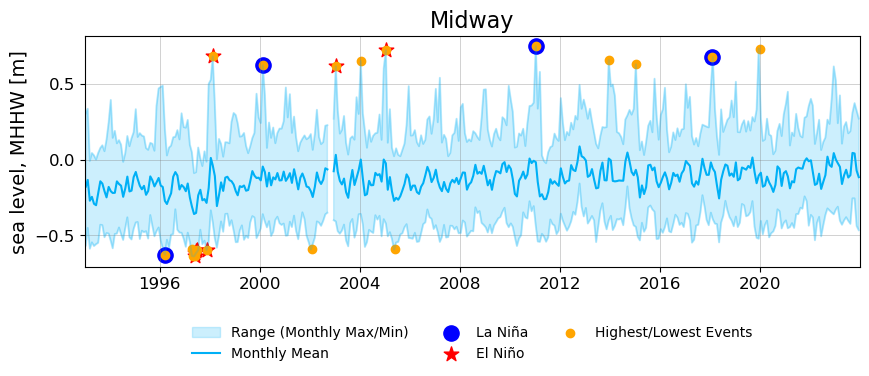

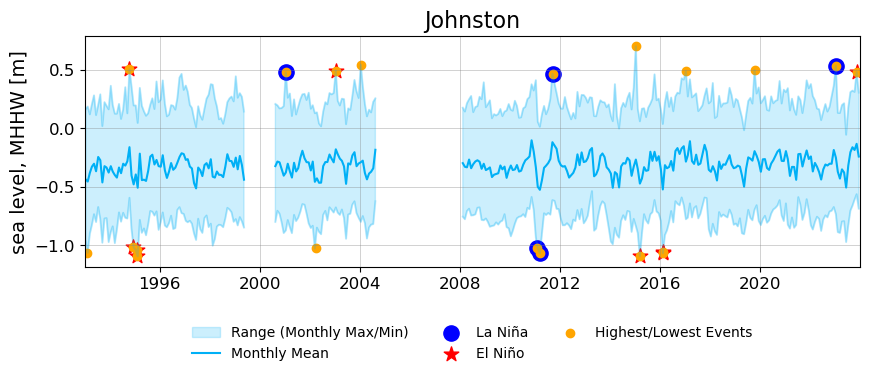

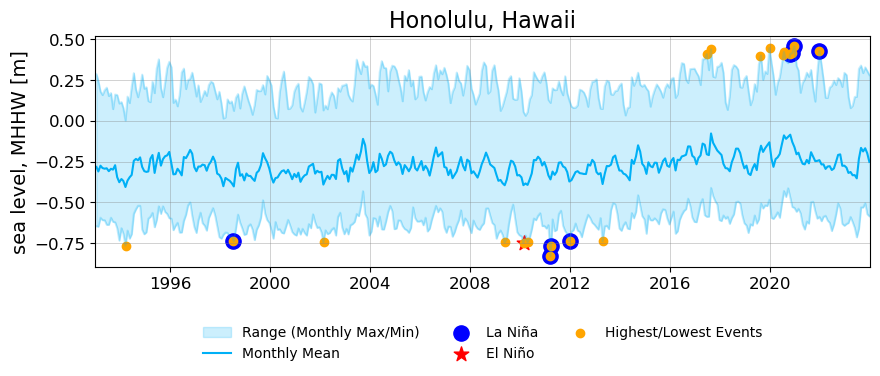

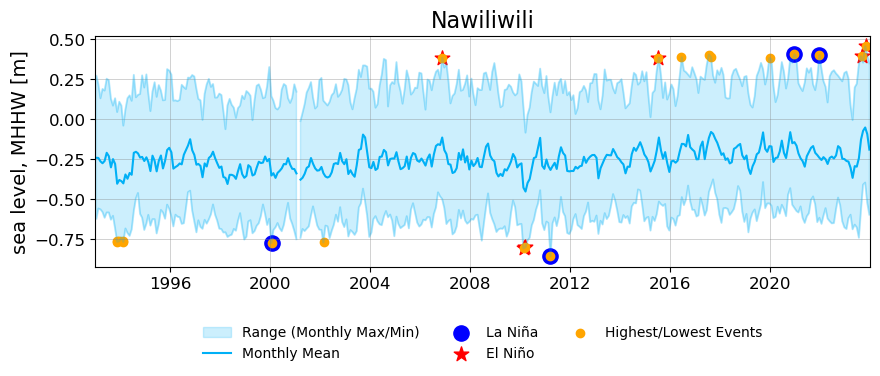

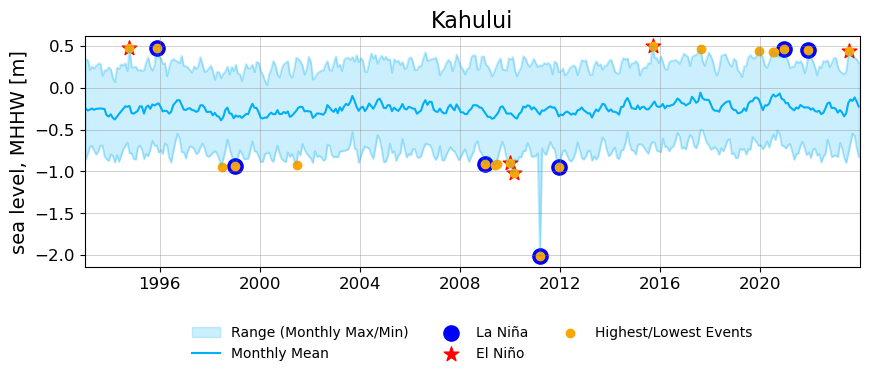

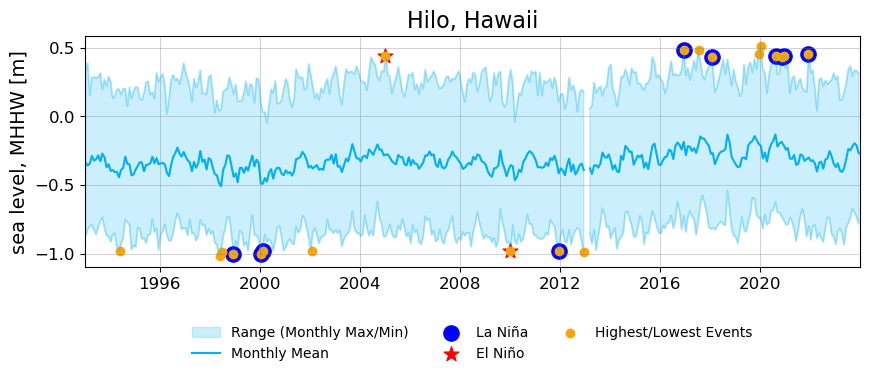

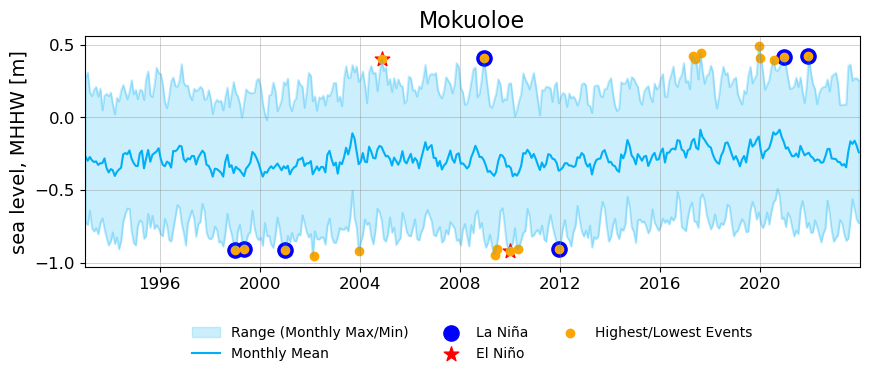

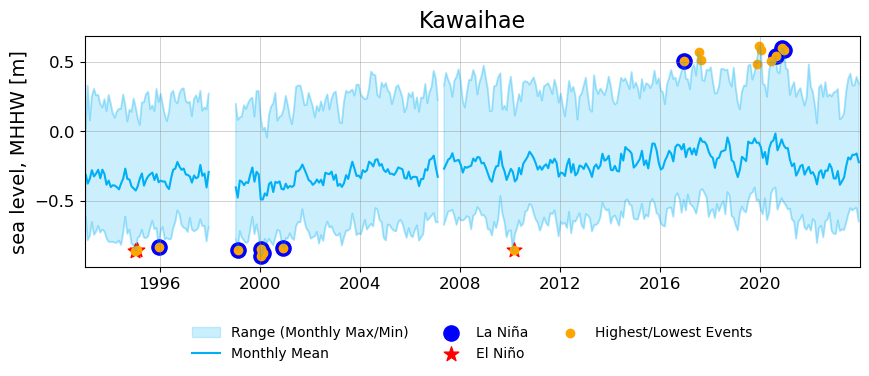

In [113]:
# static version

# Plot configuration

# loop through all the records
for i in range(len(rsl_subset.record_id)):
    rid = i
    top_10_table = get_top_10_table(rsl_subset,rid)
    # get top_10_table for each record

    fig,ax = plt.subplots(1,1,figsize=(10,3))
    
    
    ax.set_title(f'{rsl_subset["station_name"].isel(record_id=rid).values}')
    ax.set_ylabel(f'{rsl_subset["sea_level"].attrs["long_name"]} [{rsl_subset["sea_level"].attrs["units"]}]')
    
    # Plot the max, min, and mean lines
    # Plot the max, min, and mean lines
    ax.plot(x, rsl_monthly_max['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2))
    ax.plot(x, rsl_monthly_min['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2))
    ax.fill_between(x, rsl_monthly_max['sea_level'].isel(record_id=rid), 
                     rsl_monthly_min['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2), label='Range (Monthly Max/Min)')
    ax.plot(x, rsl_monthly_mean['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 1), label='Monthly Mean')
    
    # Plot the markers for La Niña, El Niño, and other events
    ax.scatter(top_10_table[top_10_table['ONI Mode']=='La Nina'].date, top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'], color='blue', s=120, label='La Niña', marker='o')
    ax.scatter(top_10_table[top_10_table['ONI Mode']=='El Nino'].date, top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'], color='red', s=120, label='El Niño', marker='*')
    ax.scatter(top_10_table.date, top_10_table['sea level (m)'], color='orange', s=36, label='Highest/Lowest Events', marker='o')
    
    # Setting the x-axis limits
    ax.set_xlim(pd.Timestamp('1993-01-01'), pd.Timestamp('2023-12-31'))
    
    # Improve the appearance
    ax.grid(True, color='gray', alpha=0.5 ,linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False, fontsize=10)
    
    
    # Save the plot to a file
    figname = 'SL_rankings_' + str(rsl_subset['station_name'].isel(record_id=rid).values) + '.png'
    fig.savefig(output_dir / figname, dpi=300, bbox_inches='tight')


glue("SL_rankings",fig,display=False)


```{glue:figure} SL_rankings
:name: "SL_rankings"

This is a static version of the previous figure. I am using this static version because there is more control over the printed figure.
```